# Машинне навчання

## Навчання без учителя: задачi кластеризацiї

## Метод k-середнiх (k-Means)


###  Лабораторна робота 6


**_Студентка Пороскун Олена. Група ПМ.м-21_**

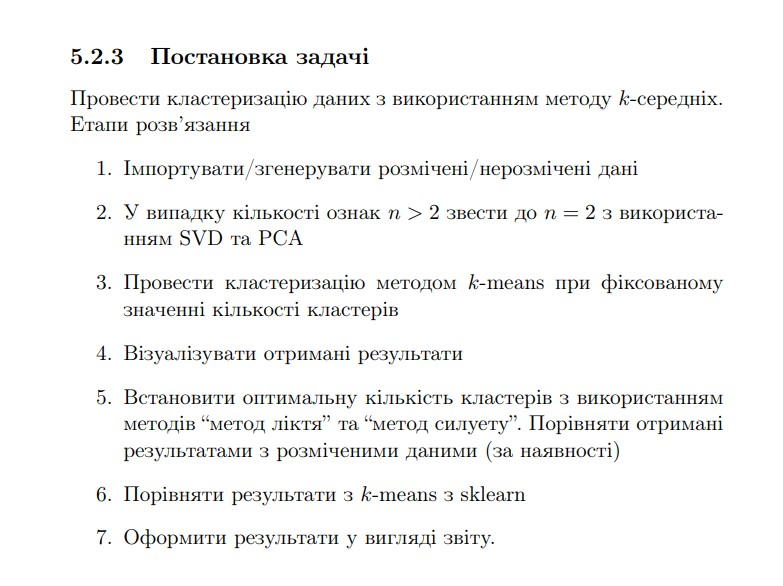

_______________________________________________________________________________________________________________

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

**1. Iмпортувати/згенерувати розмiченi/нерозмiченi данi**

In [3]:
blobs = pd.read_csv('kmeans_blobs.csv')
colnames = list(blobs.columns[1:-1])
blobs.head()

,ID,x,y,cluster
0,0,24.412,32.932,2
1,1,35.190,12.189,1
2,2,26.288,41.718,2
3,3,0.376,15.506,0
4,4,26.116,3.963,1


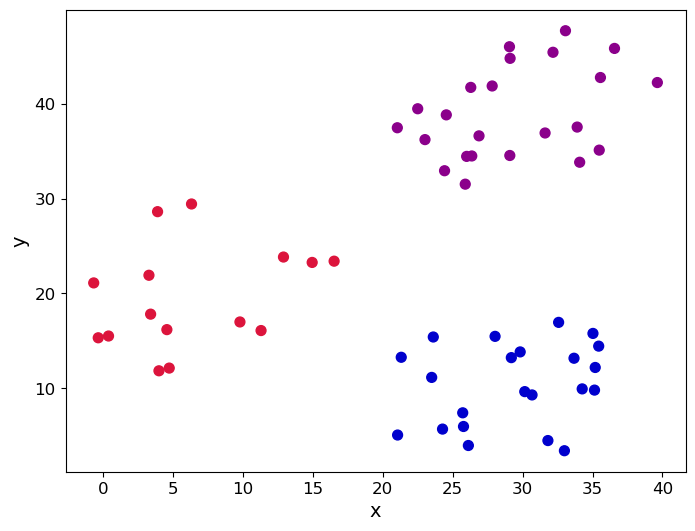

In [4]:
customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x=blobs['x'], y=blobs['y'], s=50,
            c=blobs['cluster'].astype('category'), 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**3. Провести кластеризацiю методом k-means при фiксованому значеннi кiлькостi кластерiв.**

**4. Вiзуалiзувати отриманi результати.**

Кроки 1 і 2 - Визначення та ініціювання центроїдів.

In [5]:
def initiate_centroids(k, dset):
    '''
    Вибрати k точок даних як центроїди
    k: кількість центроїдів
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

np.random.seed(42)
k=3
df = blobs[['x','y']]
centroids = initiate_centroids(k, df)
centroids

,x,y
0,24.412,32.932
5,25.893,31.515
36,26.878,36.609


Крок 3 - Розрахуйте відстань.

In [6]:
def rsserr(a,b):
    # Обчислити квадратний корінь з суми похибок. a та b - numpy масиви
    return np.square(np.sum((a-b)**2)) 

Крок 4 - Призначте центроїди.

In [7]:
def centroid_assignation(dset, centroids):
    '''
    Маючи датафрейм `dset` і набір `centroids`, ми призначаємо кожній 
    точці даних у `dset` призначаємо центроїд. 
    - dset - pandas датафрейм зі спостереженнями
    - centroids - фрейм даних з центроїдами
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Похибка оцінки
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            all_errors = np.append(all_errors, err)

        # найближчий центроїд і помилку
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

In [8]:
df['centroid'], df['error'] = centroid_assignation(df, centroids)
df.head()

,x,y,centroid,error
0,24.412,32.932,0,0.000000
1,35.190,12.189,1,211534.211314
2,26.288,41.718,2,699.601495
3,0.376,15.506,0,776856.744109
4,26.116,3.963,1,576327.599678


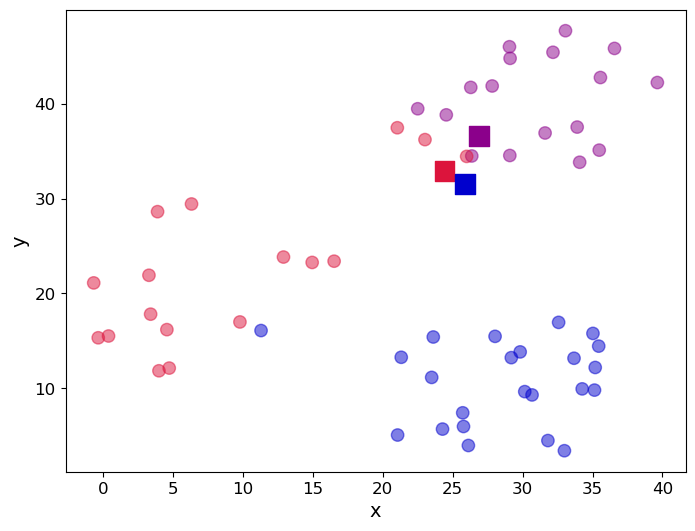

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200, c=[0, 1, 2], 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [10]:
print("Сумарна помилка is {0:.2f}".format(df['error'].sum()))

Сумарна помилка is 11927659.01


Крок 5 - Оновлення розташування центроїда.

In [11]:
centroids = df.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop = True)
centroids

,x,y
0,9.889444,23.242611
1,28.435750,11.546250
2,30.759333,40.311167


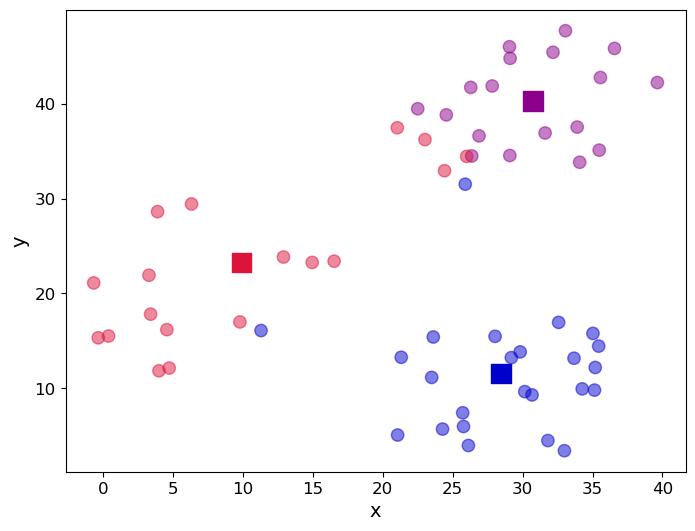

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200,
            c=[0, 1, 2], cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Крок 6 - Повторіть кроки 3-5.

In [13]:
def kmeans(dset, k=2, tol=1e-4):
    '''
    K-means реалізовано для набору 
    `dset`:  датафрей зі спостереженнями
    `k`: кількість кластерів, за замовчуванням k=2
    `tol`: допуск=1E-4
    '''
    # Давайте працювати в копії, щоб не зіпсувати оригінал
    working_dset = dset.copy()
    
    # Визначимо деякі змінні для зберігання помилки, 
    # сигналу зупинки та лічильник для ітерацій
    
    err = []
    goahead = True
    j = 0
    
    # Крок 2: Ініціюйте кластери, визначивши центроїди 
    centroids = initiate_centroids(k, dset)

    while(goahead):
        # Крок 3 і 4 - Призначення центроїдів і розрахунок похибки
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids) 
        err.append(sum(j_err))
        
        # Крок 5 - Оновлення положення центроїда
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

        # Крок 6 - Перезапустіть ітерацію
        if j>0:
            # Чи є похибка меншою за допуск (1E-4)
            if err[j-1]-err[j]<=tol:
                goahead = False
        j+=1

    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], j_err, centroids

In [14]:
np.random.seed(42)
df['centroid'], df['error'], centroids =  kmeans(df[['x','y']], 3)
df.head()

,x,y,centroid,error
0,24.412,32.932,2,3767.568743
1,35.190,12.189,1,1399.889001
2,26.288,41.718,2,262.961097
3,0.376,15.506,0,2683.086425
4,26.116,3.963,1,2723.650198


In [15]:
centroids

,x,y
0,6.322867,19.559800
1,29.330864,10.432409
2,29.304957,39.050783


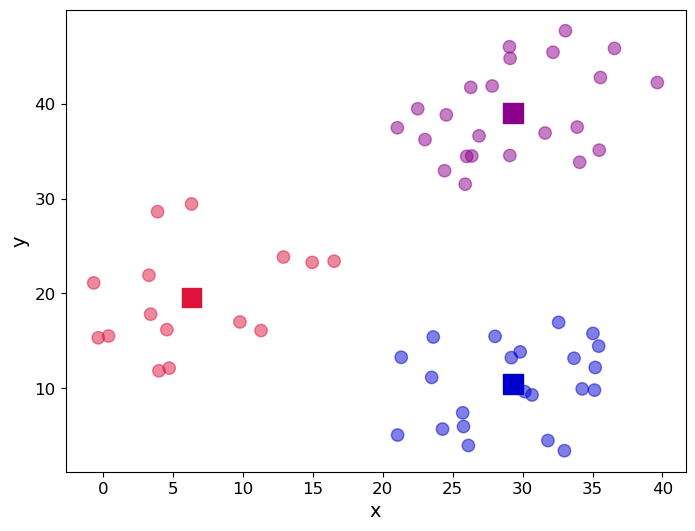

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200, c=[0, 1, 2], 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Отримали **3 групи**.У цьому конкретному прикладі дані такі, що різниця між групами є чіткою. Однак, нам може не так пощастити в кожному випадку. Тому питання про те, скільки груп існує, залишається відкритим. Ми можемо використати графік, який допоможе нам мінімізувати похибку, подивившись на запуск алгоритму з послідовністю і шукати "лікоть" на графіку, який вказує на достатню кількість кластерів для використання:

**5. Встановити оптимальну кiлькiсть кластерiв з використанням методiв “метод лiктя” / “метод силуету”. Порiвняти отриманi результатами з розмiченими даними (за наявностi).**

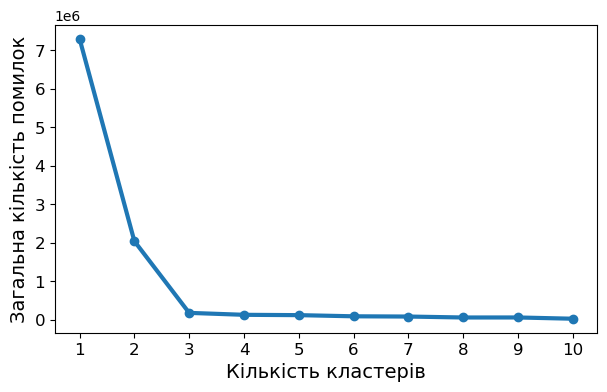

In [17]:
n = 10
err_total = []

df_elbow = blobs[['x','y']]

for i in range(n):
    working_dset, my_errs, centroids = kmeans(df_elbow, i+1)
    err_total.append(sum(my_errs))
    
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(range(1,n+1), err_total, linewidth=3, marker='o')
ax.set_xlabel(r'Кількість кластерів', fontsize=14)
ax.set_ylabel(r'Загальна кількість помилок', fontsize=14)
plt.xticks(range(1, n+1), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Тепер ми можемо застосувати "правило ліктя", яке є евристичним прийомом, що допоможе нам визначити кількість кластерів. Якщо уявити лінію, зображену вище, як руку, то "лікоть" - це точка перегину. У цьому випадку "лікоть" знаходиться між 2 і 4 кластерами, що вказує нам на те, що **вибір 3 є правильним**.

**Порiвняти отриманi результатами з розмiченими даними (за наявностi).**

In [18]:
blobs = pd.read_csv('kmeans_blobs.csv')
blobs.head()

,ID,x,y,cluster
0,0,24.412,32.932,2
1,1,35.190,12.189,1
2,2,26.288,41.718,2
3,3,0.376,15.506,0
4,4,26.116,3.963,1


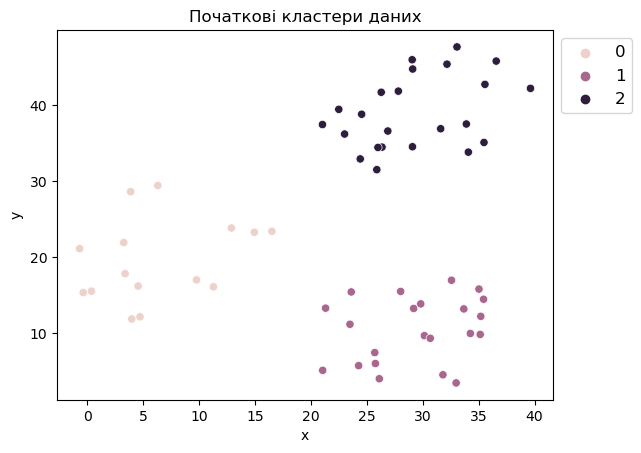

In [19]:
sns.scatterplot(x = blobs['x'], y = blobs['y'], hue = blobs['cluster'])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Початкові кластери даних" )
plt.legend(bbox_to_anchor=(1,1), loc="upper left", prop={'size': 12})
plt.show()

**6. Порiвняти результати з k-means з sklearn**

In [20]:
from sklearn.cluster import KMeans

In [21]:
data = pd.read_csv('kmeans_blobs.csv')
data.head()

,ID,x,y,cluster
0,0,24.412,32.932,2
1,1,35.190,12.189,1
2,2,26.288,41.718,2
3,3,0.376,15.506,0
4,4,26.116,3.963,1


In [22]:
data_xy = data[['x', 'y']]
data_xy.head()

,x,y
0,24.412,32.932
1,35.190,12.189
2,26.288,41.718
3,0.376,15.506
4,26.116,3.963


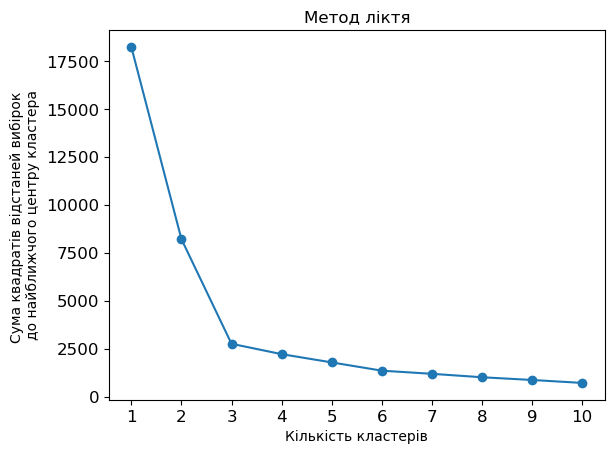

In [23]:
inertias = []
n=10
for i in range(1,n+1):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_xy)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Метод ліктя')
plt.xlabel('Кількість кластерів')
plt.ylabel('Сума квадратів відстаней вибірок \nдо найближчого центру кластера')
plt.xticks(range(1, n+1), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

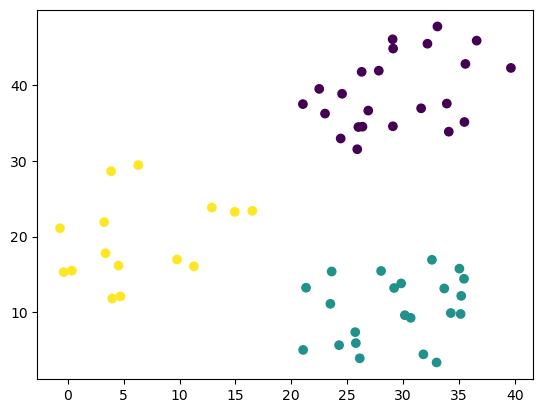

In [24]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_xy)

plt.scatter(data_xy['x'], data_xy['y'], c=kmeans.labels_)
plt.show()

_______________________________________________________________________________________________________________